## Постановка задачи

Поставлена задача бинарной классификации музыкальных композиций. Требуется определить, станет ли музыкальная композиция популярна на основе предоставленных данных о популярности музыкальных композиций за последние 50 лет.

Инициализация

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import pandas as pd 
import seaborn as sns
import sklearn
import math

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import parallel_backend
from sklearn.metrics import f1_score
from tqdm import tqdm

from IPython.core.display import display, HTML

css  = "<style>";
css += ".output.output_scroll { height:auto !important; box-shadow:none !important; }";
css += ".output_stderr { background:white !important; }";
css += "</style>"

display(HTML(css))

Загружаем данные:

In [2]:
dataset_urls = {
    "60s" : "https://raw.githubusercontent.com/AUXLander/MachineLearning/master/datasets/dataset-of-60s.csv",
    "70s" : "https://raw.githubusercontent.com/AUXLander/MachineLearning/master/datasets/dataset-of-70s.csv",
    "80s" : "https://raw.githubusercontent.com/AUXLander/MachineLearning/master/datasets/dataset-of-80s.csv",
    "90s" : "https://raw.githubusercontent.com/AUXLander/MachineLearning/master/datasets/dataset-of-90s.csv",
    "00s" : "https://raw.githubusercontent.com/AUXLander/MachineLearning/master/datasets/dataset-of-00s.csv",
    "10s" : "https://raw.githubusercontent.com/AUXLander/MachineLearning/master/datasets/dataset-of-10s.csv",
    "all" : "https://raw.githubusercontent.com/AUXLander/MachineLearning/master/datasets/dataset-of-all.csv"
};

Выберем год

In [3]:
dataurl = dataset_urls["all"];
dataraw = pd.read_csv(dataurl);

Размеры таблицы:

In [4]:
dataraw.shape

(41106, 19)

Отобразим первые строки:

In [5]:
dataraw.head()

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target
0,Lucky Man,Montgomery Gentry,spotify:track:4GiXBCUF7H6YfNQsnBRIzl,0.578,0.471,4,-7.270,1,0.0289,0.368000,0.00000,0.159,0.532,133.061,196707,4,30.88059,13,1
1,On The Hotline,Pretty Ricky,spotify:track:1zyqZONW985Cs4osz9wlsu,0.704,0.854,10,-5.477,0,0.1830,0.018500,0.00000,0.148,0.688,92.988,242587,4,41.51106,10,1
2,Clouds Of Dementia,Candlemass,spotify:track:6cHZf7RbxXCKwEkgAZT4mY,0.162,0.836,9,-3.009,1,0.0473,0.000111,0.00457,0.174,0.300,86.964,338893,4,65.32887,13,0
3,"Heavy Metal, Raise Hell!",Zwartketterij,spotify:track:2IjBPp2vMeX7LggzRN3iSX,0.188,0.994,4,-3.745,1,0.1660,0.000007,0.07840,0.192,0.333,148.440,255667,4,58.59528,9,0
4,I Got A Feelin',Billy Currington,spotify:track:1tF370eYXUcWwkIvaq3IGz,0.630,0.764,2,-4.353,1,0.0275,0.363000,0.00000,0.125,0.631,112.098,193760,4,22.62384,10,1


Признаки:
* Track - название композиции
* Artist - исполнитель
* Uri - ссылка на композицию в Spotify
* Danceability - численная оценка от 0 до 1 описывает, насколько композияция подходит для танцев.
* Energy - численная оценка, которая описывает общую эмоциональную активность и энергичность музыкальной композиции. 
* Key - величина, которая описывает общую тональность музыкальной композиции, где 0 = Ля, 1 = Ля минор, 2 = Си бемоль и т.д., иначе, если тональность не определена = -1.
* Loudness - величина, описывающая громкость музыкальной копозиции в dB.
* Mode - признак, который определяет модальность: мажор - 1, а минор - 0.
* Speechiness - численная оценка от 0 до 1, которая описывает преобладание речи в музыкальной композиции. Значения выше 0,66 описывают треки, которые, вероятно, полностью состоят из произнесенных слов. Значения от 0,33 до 0,66 описывают дорожки, которые могут содержать как музыку, так и речь, как по частям, так и по слоям, включая такие случаи, как рэп. Значения ниже 0,33, скорее всего, представляют музыку и другие треки, не похожие на речь.
* Acousticness - численная оценка от 0 до 1, которая описывает вероятность чисто аккустического исполнения музыкальной композиции.
* Instrumentalness - численная оценка от 0 до 1, которая описывает вероятность отсутствия вокала в данной композиции. Чем выше оценка, тем ниже вероятность наличия вокала.
* Liveness - численная оценка от 0 до 1, которая описывает вероятность записи музыкальной композиции вживую. Оценка выше 0.8 означает высокую вероятность исполнения вживую.
* Valence - численное оценка от 0 до 1, которая описывает общий положительный эмоциональный настрой композиции от наиболее негативных и грустных - 0, к наиболее счастливым и радостным - 1.
* Tempo - величина, описывающая темп музыкальной композиции, количество ударов в минуту (BPM).
* Duration - величина, описывающая продолжительность музыкальной композиции в миллисекундах.
* Time signature - величина, описывающая количество ударов в каждом такте.
* Chorus hit - временная отметка, когда начинается третья секция музыкальной композиции (?)
* Sections - величина, описывающая количество секций в музыкальной композиции (?). 
* Target - признак, который принимает значение "1", если музыкальная композиция стала хитом, и "0" иначе.

Признак 'target' является целевым признаком!

# Визуализация данных и вычисление основных характеристик

Имена признаков в датасете:

In [6]:
dataraw.columns

Index(['track', 'artist', 'uri', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature', 'chorus_hit',
       'sections', 'target'],
      dtype='object')

Сразу избавимся от признаков, которые априорно не оказывают влияние на популярность музыкальных композиций:

In [7]:
del dataraw['track']
del dataraw['artist']
del dataraw['uri']

In [8]:
dataraw.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target
count,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,4.110600e+04,41106.000000,41106.000000,41106.000000,41106.000000
mean,0.539695,0.579545,5.213594,-10.221525,0.693354,0.072960,0.364197,0.154416,0.201535,0.542440,119.338249,2.348776e+05,3.893689,40.106041,10.475673,0.500000
std,0.177821,0.252628,3.534977,5.311626,0.461107,0.086112,0.338913,0.303530,0.172959,0.267329,29.098845,1.189674e+05,0.423073,19.005515,4.871850,0.500006
min,0.000000,0.000251,0.000000,-49.253000,0.000000,0.000000,0.000000,0.000000,0.013000,0.000000,0.000000,1.516800e+04,0.000000,0.000000,0.000000,0.000000
25%,0.420000,0.396000,2.000000,-12.816000,0.000000,0.033700,0.039400,0.000000,0.094000,0.330000,97.397000,1.729278e+05,4.000000,27.599792,8.000000,0.000000
50%,0.552000,0.601000,5.000000,-9.257000,1.000000,0.043400,0.258000,0.000120,0.132000,0.558000,117.565000,2.179070e+05,4.000000,35.850795,10.000000,0.500000
75%,0.669000,0.787000,8.000000,-6.374250,1.000000,0.069800,0.676000,0.061250,0.261000,0.768000,136.494000,2.667730e+05,4.000000,47.625615,12.000000,1.000000
max,0.988000,1.000000,11.000000,3.744000,1.000000,0.960000,0.996000,1.000000,0.999000,0.996000,241.423000,4.170227e+06,5.000000,433.182000,169.000000,1.000000


Признаки с неограниченным множеством принимаемых значений:

In [9]:
unlimited_value_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms'];

Признаки с ограниченным множеством принимаемых значений:

In [10]:
enumerated_value_features = ['key', 'mode', 'time_signature'];

Покажем их преобладание среди множества данных:

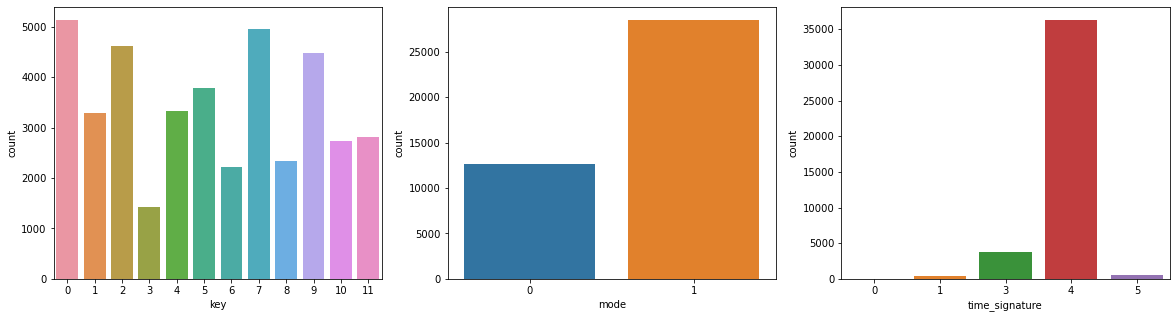

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

index = 0

for feature in enumerated_value_features:
    sns.countplot(x = feature, data = dataraw, ax = ax[index])
    index = index + 1

На полученных графиках выделяется признак time_signature, который принимает значения 0, 1 и 5 очень малое количество раз:

In [12]:
for time_signature in range(0,5):
    print(time_signature, ":", np.sum(dataraw['time_signature'] == time_signature))

0 : 3
1 : 371
2 : 0
3 : 3840
4 : 36297


Признаки с малым количеством вхождений (< 50) можно отбросить:

In [13]:
for time_signature in range(0,5):
    if(np.sum(dataraw['time_signature'] == time_signature) < 50):
        dataraw = dataraw[dataraw['time_signature'] != time_signature]
        
for time_signature in range(0,5):
    print(time_signature, ":", np.sum(dataraw['time_signature'] == time_signature))

0 : 0
1 : 371
2 : 0
3 : 3840
4 : 36297


Таблица корреляции признаков:

In [14]:
datacorr = dataraw.corr()
datacorr

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target
danceability,1.000000,0.206139,0.015554,0.274179,-0.032801,0.156455,-0.261254,-0.302004,-0.115241,0.553728,-0.067004,-0.063100,0.190761,-0.036005,-0.058723,0.346165
energy,0.206139,1.000000,0.022597,0.772648,-0.033794,0.122393,-0.715048,-0.208169,0.157794,0.341415,0.224004,0.011814,0.196249,0.009463,-0.040254,0.177154
key,0.015554,0.022597,1.000000,0.008485,-0.140427,0.026551,-0.024257,-0.013090,0.000643,0.007841,0.001304,0.015513,0.005239,0.010302,0.006813,0.009868
loudness,0.274179,0.772648,0.008485,1.000000,0.000598,0.069247,-0.566555,-0.374328,0.086649,0.271713,0.169489,-0.049914,0.165302,-0.013336,-0.080099,0.285976
mode,-0.032801,-0.033794,-0.140427,0.000598,1.000000,-0.059675,0.049998,-0.076020,0.008943,0.035626,0.026951,-0.074841,-0.009552,-0.022715,-0.057111,0.079689
speechiness,0.156455,0.122393,0.026551,0.069247,-0.059675,1.000000,-0.083902,-0.084103,0.131516,0.001500,0.036795,0.007622,0.021022,0.012885,-0.008646,-0.040810
acousticness,-0.261254,-0.715048,-0.024257,-0.566555,0.049998,-0.083902,1.000000,0.204157,-0.030784,-0.195281,-0.179635,-0.070257,-0.188286,-0.012256,-0.016803,-0.246072
instrumentalness,-0.302004,-0.208169,-0.013090,-0.374328,-0.076020,-0.084103,0.204157,1.000000,-0.050564,-0.287094,-0.053672,0.106548,-0.078250,0.048649,0.081184,-0.407633
liveness,-0.115241,0.157794,0.000643,0.086649,0.008943,0.131516,-0.030784,-0.050564,1.000000,0.000793,0.024947,0.005343,0.004805,0.038067,-0.011733,-0.051499
valence,0.553728,0.341415,0.007841,0.271713,0.035626,0.001500,-0.195281,-0.287094,0.000793,1.000000,0.107627,-0.172233,0.154901,-0.058942,-0.133618,0.251149


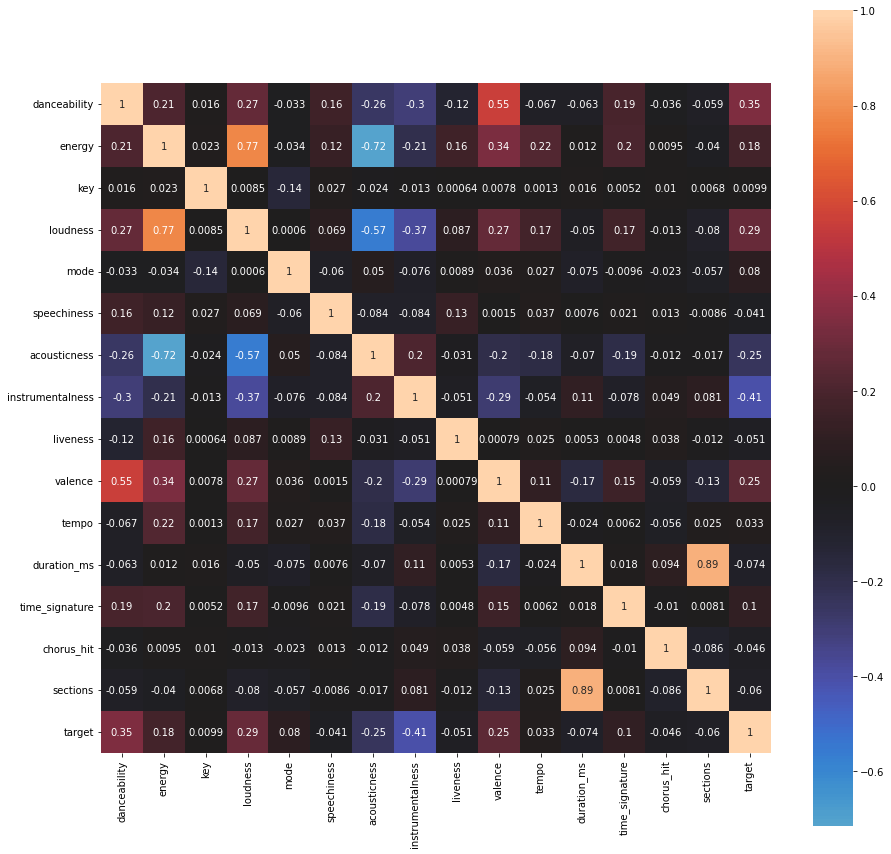

In [15]:
f, ax = plt.subplots(figsize=(15, 15))

ax = sns.heatmap(datacorr, center = 0, annot = True, square = True)
pass

Выделим признаки с наибольшей и наименьшей корреляцией c target. На основе предоставленой выше таблицы выберем пороговое значение epsilon_min и epsilon_max:

In [16]:
epsilon_max = 0.40
epsilon_min = 0.06

datacorr_max = datacorr[abs(datacorr) > epsilon_max]['target'].sort_values(key = lambda x: abs(x))
datacorr_min = datacorr[abs(datacorr) < epsilon_min]['target'].sort_values(key = lambda x: abs(x))

def process_correlation(data) :
    datacorr_max = []
    datacorr_sgn = []
    for feature in unlimited_value_features:
        if (math.isnan(data[feature]) == 0):
            datacorr_sgn.append(feature)
            datacorr_max.append(data[feature])

    return pd.DataFrame(datacorr_max, datacorr_sgn, ['Корреляция с target'])

Наибольшую отрицательную корреляцию имеет признак инструментальность:

In [17]:
process_correlation(datacorr_max)

,Корреляция с target
instrumentalness,-0.407633


Это означает, что чем выше оценка инструментальности, тем меньше вероятность стать хитом для этой музыкальной композиции. 

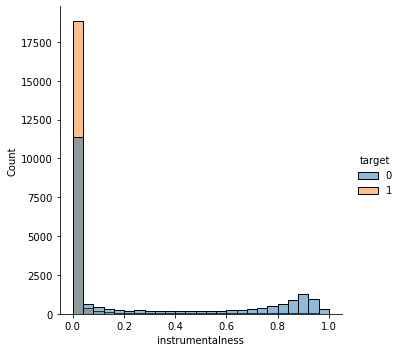

In [18]:
sns.displot(dataraw, x='instrumentalness', bins = 25, hue = 'target')
pass

Наименьшую корреляцию имеет следующая группа признаков:

In [19]:
process_correlation(datacorr_min)

,Корреляция с target
speechiness,-0.040810
liveness,-0.051499
tempo,0.032697


Это означает, что признаки данной группы оказывают наименьшее влияние на популярность музыкальных композиций. (*)

# Обработка выбросов

Выведем гистаграммы признаков музыкальных композиций:

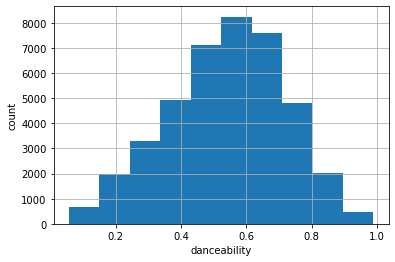

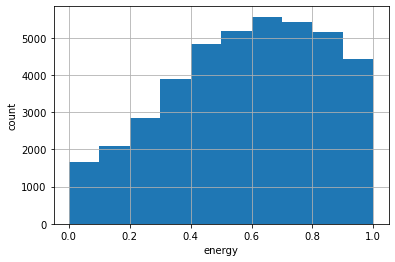

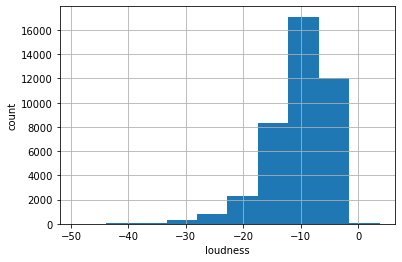

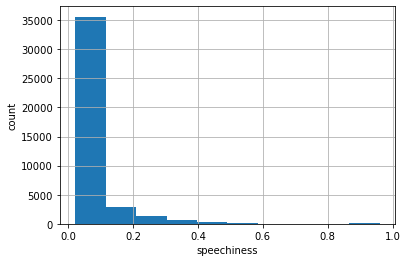

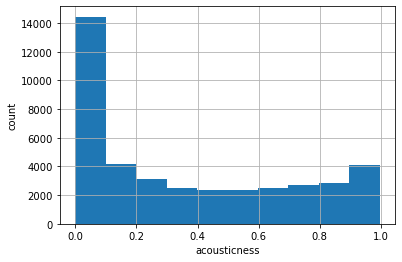

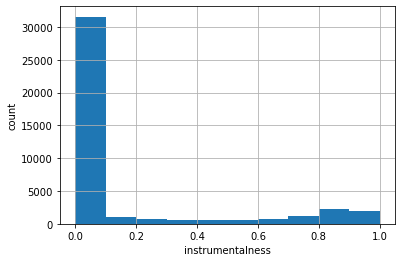

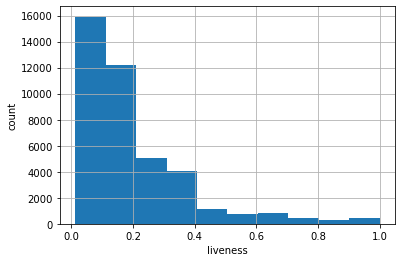

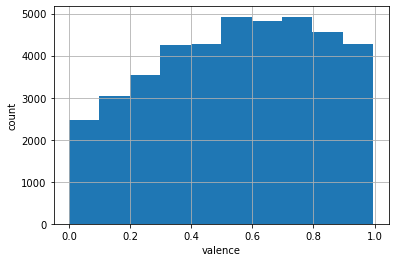

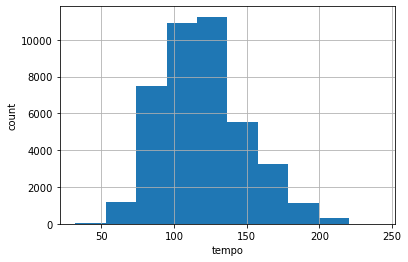

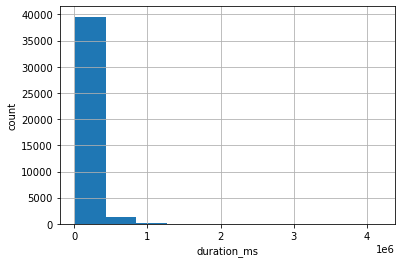

In [20]:
for feature in unlimited_value_features:
    data = dataraw.copy();
    data[feature].hist();
    plt.xlabel(feature);
    plt.ylabel("count");
    plt.show();
    

Гистограмма loudness говорит о наличии музыкальных композиций громкостью более 0 dB. Их количество:

In [21]:
np.sum(dataraw['loudness'] > 0)

6

Гистограмма speechiness говорит о наличии музыкальных композиций с оценкой более 0.6 единиц. Их количество:

In [22]:
np.sum(dataraw['speechiness'] > 0.6)

164

Гистограмма tempo говорит о наличии музыкальных композиций с темпом менее 50 ударов в сек. Их количество:

In [23]:
np.sum(dataraw['tempo'] < 50)

42

Гистограмма duration_ms говорит о наличии музыкальных композиций протодолжительностью более 1 000 000 мс. Их количество:

In [24]:
np.sum(dataraw['duration_ms'] > 1*1e6)

134

Выведем ящик с усами признаков хитов:

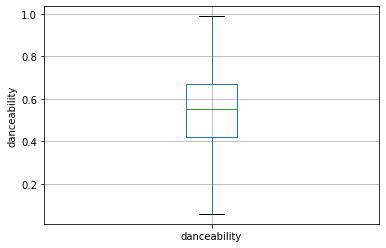

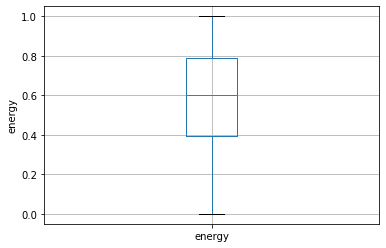

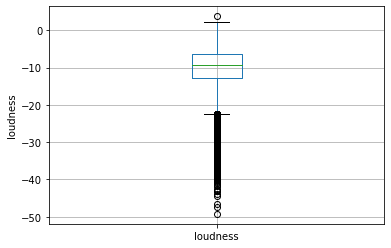

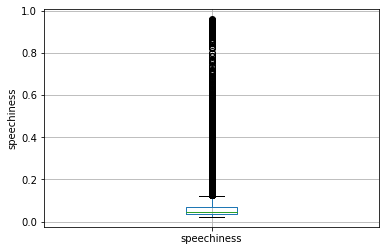

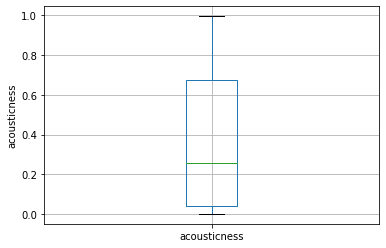

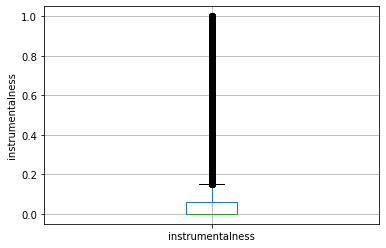

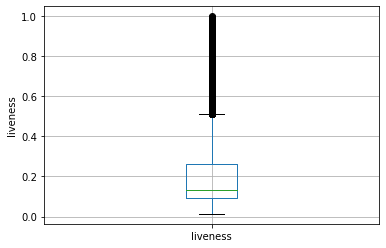

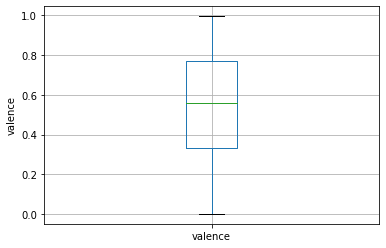

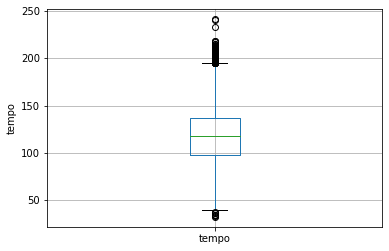

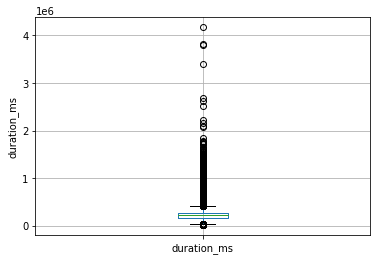

In [25]:
for feature in unlimited_value_features:
    data = dataraw.copy();
    data.boxplot(column = feature)
    plt.ylabel(feature)
    plt.show()
    

Принято считать выбросами значения, относящимися в областях ниже 1 и выше 3 квартилей, поэтому избавляемся от них:

In [26]:
rows_to_drop = dataraw[
    (dataraw['duration_ms']  < dataraw['duration_ms'].quantile(0.005)) |
    (dataraw['duration_ms']  > dataraw['duration_ms'].quantile(0.955)) |
    (dataraw['tempo']        > dataraw['tempo'].quantile(0.955))       |
    (dataraw['loudness']     > 0.0)                                    | 
    (dataraw['speechiness']  > 0.6)                                    | 
    (dataraw['tempo']        < 50)                                     |
    (dataraw['duration_ms']  > 1e6)
].index

cropped_dataraw = dataraw.drop(rows_to_drop).reset_index()

Покажем разность размера в выборках:

In [27]:
dataraw.shape[0] - cropped_dataraw.shape[0]

4011

## Обработка пропущенных значений

В данном решении пропущенные значения отсутствуют:

In [28]:
cropped_dataraw.isna().sum()

index               0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
chorus_hit          0
sections            0
target              0
dtype: int64

## Обработка категориальных признаков

Проведем бинаризацию признака mode:

In [29]:
minor = pd.DataFrame({"minor" : cropped_dataraw["mode"].copy()})
major = pd.DataFrame({"major" : cropped_dataraw["mode"].copy()})

for i in range(0, major.shape[0]):
    major["major"][i] = (2 * major["major"][i] + 1) % 3;

# При слиянии повился фиктивный признак index
cropped_dataraw = pd.concat((cropped_dataraw, minor, major), axis = 1).drop(columns=['mode', 'index'])
cropped_dataraw.columns

Index(['danceability', 'energy', 'key', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature', 'chorus_hit', 'sections', 'target',
       'minor', 'major'],
      dtype='object')

## Нормализация данных

In [30]:
active_features = list(cropped_dataraw.columns)
active_features.remove('target')

data_normalized = cropped_dataraw.copy()
data_normalized[active_features] = data_normalized[active_features].apply(lambda x: (x - np.mean(x)) / (np.std(x)))

data = data_normalized.copy()
data.describe()

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,minor,major
count,3.709200e+04,3.709200e+04,3.709200e+04,3.709200e+04,3.709200e+04,3.709200e+04,3.709200e+04,3.709200e+04,3.709200e+04,3.709200e+04,3.709200e+04,3.709200e+04,3.709200e+04,3.709200e+04,37092.000000,3.709200e+04,3.709200e+04
mean,1.795965e-14,6.033451e-15,-2.274802e-19,1.027886e-14,-1.028359e-14,2.829252e-15,-8.900312e-17,1.803298e-15,2.165751e-14,8.842331e-15,5.716996e-16,-1.080903e-14,1.667846e-14,9.288429e-15,0.522808,6.159140e-15,-6.159140e-15
std,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,0.499486,1.000013e+00,1.000013e+00
min,-2.843580e+00,-2.344460e+00,-1.471646e+00,-7.597248e+00,-6.661973e-01,-1.068955e+00,-4.836831e-01,-1.099675e+00,-2.093004e+00,-2.597152e+00,-2.524563e+00,-7.066840e+00,-2.167618e+00,-3.274561e+00,0.000000,-1.520261e+00,-6.577817e-01
25%,-6.496360e-01,-7.231458e-01,-9.062223e-01,-4.925033e-01,-5.040604e-01,-9.502041e-01,-4.836831e-01,-6.226384e-01,-7.895445e-01,-7.667700e-01,-7.225563e-01,2.376269e-01,-6.703837e-01,-6.283734e-01,0.000000,-1.520261e+00,-6.577817e-01
50%,7.167663e-02,8.801523e-02,-5.808658e-02,1.766663e-01,-3.699649e-01,-3.170664e-01,-4.833971e-01,-3.997078e-01,6.679781e-02,-2.067152e-02,-6.585503e-02,2.376269e-01,-2.289177e-01,3.317366e-02,1.000000,6.577817e-01,-6.577817e-01
75%,7.179727e-01,8.188633e-01,7.900491e-01,7.226673e-01,-1.189760e-02,9.032603e-01,-3.660439e-01,3.531977e-01,8.407267e-01,6.728405e-01,5.979453e-01,2.376269e-01,4.046092e-01,6.947207e-01,1.000000,6.577817e-01,1.520261e+00
max,2.518369e+00,1.670181e+00,1.638185e+00,1.916042e+00,7.631186e+00,1.902794e+00,2.923680e+00,4.700051e+00,1.680965e+00,2.332921e+00,2.942612e+00,2.672449e+00,1.200801e+01,5.656323e+00,1.000000,6.577817e-01,1.520261e+00


## Классфикатор ближайших соседей

Определим функции для обработки и визуализации данных:

In [31]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import parallel_backend
from sklearn.metrics import f1_score
from tqdm import tqdm

def split_data(cdata):
    data_x = np.array(cdata.drop(['target'], axis=1))
    data_y = np.array(cdata['target'])

    return train_test_split(data_x, data_y, test_size = 0.25, random_state = 123)

def process_data(x_train, x_test, y_train, y_test, iterator):
    y_train_prediction = []
    y_test_prediction = []
    
    for count in tqdm(iterator):
        model = KNeighborsClassifier(n_jobs = -1, n_neighbors = count)
        model.fit(x_train, y_train)

        y_train_prediction.append(model.predict(x_train))
        y_test_prediction.append(model.predict(x_test))
        
    print('Обучение завершено!')
    
    return y_train_prediction, y_test_prediction, iterator

def draw_learning_result(x_train, x_test, y_train, y_test, y_train_prediction, y_test_prediction, iterator):
    f, ax = plt.subplots(figsize=(8, 8))

    ithistory = list(iterator)[::-1]
    
    rs_train = []
    rs_test = []

    for i in range(len(iterator)):
        rs_train.append(np.mean(y_train != y_train_prediction[i]))
        rs_test.append(np.mean(y_test != y_test_prediction[i]))

    rs_train_history = rs_train[::-1];
    rs_test_history = rs_test[::-1];

    plt.scatter(ithistory, rs_train_history, label = 'ошибка обучения', color='#42A5F5')
    plt.scatter(ithistory, rs_test_history, label = 'ошибка тренировки', color='#66BB6A')

    plt.plot(ithistory, rs_train_history, color='#42A5F5')
    plt.plot(ithistory, rs_test_history, color='#66BB6A')

    plt.grid()
    plt.legend()
    
    return rs_train, rs_test

Распределение тренировочных и тестовых данных:

In [32]:
x_train, x_test, y_train, y_test = split_data(data)

# Обучение классификатора

In [33]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

def classifier(sizes):
    return MLPClassifier(hidden_layer_sizes = sizes,
                         solver = 'lbfgs', 
                         max_iter = 10000,
                         activation = 'logistic',
                         random_state = 42)

def classifier_opt(alpha_opt, sizes):
    return MLPClassifier(alpha = alpha_opt,
                         hidden_layer_sizes = sizes,
                         solver = 'lbfgs', 
                         max_iter = 10000,
                         activation = 'logistic',
                         random_state = 42)

def alpha_plot(data, train_err, test_err, name_data = 'Alpha', name_err = 'Error'):
    plt.semilogx(data, train_err, 'b-o', label = 'train')
    plt.semilogx(data, test_err, 'r-o', label = 'test')
    plt.xlim([np.min(data), np.max(data)])
    plt.title('%s vs %s' % (name_err, name_data))
    plt.xlabel(name_data)
    plt.ylabel(name_err)
    plt.legend()
    pass

Разбиваем данные на обучающую и тестовую выборки:

In [34]:
data = data_normalized.copy();
data_x = np.array(data.drop(['target'], axis=1));
data_y = np.array(data['target']);
 
x_train, x_test, y_train, y_test = train_test_split(data_x, 
                                                    data_y, 
                                                    test_size = 0.33, 
                                                    stratify = data_y, 
                                                    random_state = 42);
print(x_train.shape)
print(x_test.shape)

(24851, 16)
(12241, 16)


In [35]:
%%time
mlp_model = classifier((100,))
mlp_model.fit(x_train, y_train)

y_train_pred = mlp_model.predict(x_train)
y_test_pred = mlp_model.predict(x_test)

pass

Wall time: 9min 1s


In [36]:
x_train.shape, x_test.shape

((24851, 16), (12241, 16))

Ошибка на обучающей выборке:

In [37]:
1.0 - accuracy_score(y_train, y_train_pred)

0.1384652529073277

Ошибка на тестовой выборке:

In [38]:
1.0 - accuracy_score(y_test, y_test_pred)

0.26746180867576175

In [39]:
%%time
mlp_model = classifier((50,))
mlp_model.fit(x_train, y_train)

y_train_pred = mlp_model.predict(x_train)
y_test_pred = mlp_model.predict(x_test)

pass

Wall time: 1min 59s


In [40]:
x_train.shape, x_test.shape

((24851, 16), (12241, 16))

Ошибка обучающей выборки:

In [41]:
1.0 - accuracy_score(y_train, y_train_pred)

0.18321194318136091

Ошибка тестовой выборки:

In [42]:
1.0 - accuracy_score(y_test, y_test_pred)

0.2506331182092967

In [43]:
%%time
mlp_model = classifier((25,))
mlp_model.fit(x_train, y_train)

y_train_pred = mlp_model.predict(x_train)
y_test_pred = mlp_model.predict(x_test)

pass

Wall time: 49.8 s


Ошибка обучающей выборки:

In [44]:
1.0 - accuracy_score(y_train, y_train_pred)

0.20385497565490318

Ошибка тестовой выборки:

In [45]:
1.0 - accuracy_score(y_test, y_test_pred)

0.23339596438199495

# Подбор гиперпараметров

Как видно, при использлвани слоя из 50 нейронов результаты получаются лучше (ошибка на тестовой выборке меньше), поэтому будем проводить обучение классификатора для одного скрытого слоя из 25 нейронов.

Модель с одним скрытым слоем и 25 нейронами. Поиск оптимального значения параметра регуляризации
alpha:

In [46]:
%%time
alpha_arr = np.logspace(-3, 2, 25 + 1)

test_err = []
test_acc = []
train_err = []
train_acc = []

for alpha in tqdm(alpha_arr):
    mlp_model = classifier_opt(alpha, (25,))
    mlp_model.fit(x_train, y_train)
    
    y_train_pred = mlp_model.predict(x_train)
    y_test_pred = mlp_model.predict(x_test)
 
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))

min_train_err = np.min(train_err)
min_test_err = np.min(test_err)

alpha_opt = alpha_arr[test_err == min_test_err]
alpha_opt = alpha_opt[0]

100%|██████████| 26/26 [07:55<00:00, 18.29s/it]

Wall time: 7min 55s


Минимальная ошибка на обучающей выборке:

In [47]:
min_train_err

0.20425737394873444

Минимальная ошибка на тестовой выборке:

In [48]:
min_test_err

0.23086349154480842

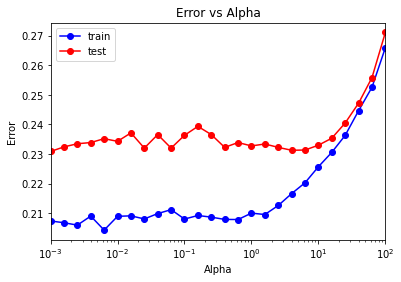

In [49]:
alpha_plot(alpha_arr, train_err, test_err, 'Alpha', 'Error')

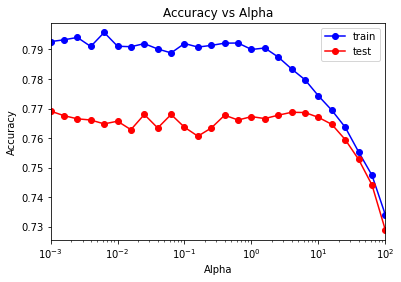

In [50]:
alpha_plot(alpha_arr, train_acc, test_acc, 'Alpha', 'Accuracy')

Оптимальный параметр alpha:

In [51]:
alpha_opt

0.001

# Обучение классификатора при оптимальном значении alpha

In [52]:
%%time
mlp_model = classifier_opt(alpha_opt, (25,))
mlp_model.fit(x_train, y_train)

y_train_pred = mlp_model.predict(x_train)
y_test_pred = mlp_model.predict(x_test)

train_mean = np.mean(y_train != y_train_pred)
test_mean = np.mean(y_test != y_test_pred)

Wall time: 1min 17s


Ошибка на обучающей выборке:

In [53]:
train_mean

0.20735584081123495

Ошибка на тренировочной выборке:

In [54]:
test_mean

0.23086349154480842

Оптимальное количество нейронов:

In [55]:
%%time
hidden_layer = np.arange(1, 25 + 1)

test_err = []
test_acc = []
train_err = []
train_acc = []

for neuroitem in tqdm(hidden_layer):
    mlp_model = classifier_opt(alpha_opt, (neuroitem,))
    mlp_model.fit(x_train, y_train)

    y_train_pred = mlp_model.predict(x_train)
    y_test_pred = mlp_model.predict(x_test)
    
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))
    
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)

neuron_opt_1 = hidden_layer[test_err == min_test_err]
neuron_opt_1 = neuron_opt_1[0]

100%|██████████| 25/25 [08:30<00:00, 20.40s/it]

Wall time: 8min 30s


Минимальная ошибка на обучающей выборке:

In [56]:
min_train_err

0.20582672729467627

Минимальная ошибка на тестовой выборке:

In [57]:
min_test_err

0.22988317947880074

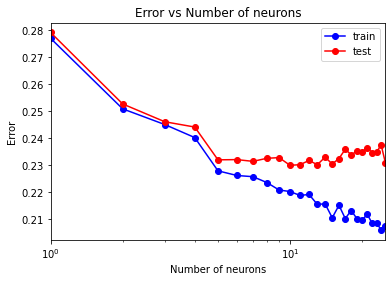

In [58]:
alpha_plot(hidden_layer, train_err, test_err, 'Number of neurons', 'Error')

Изменение метрики в зависимости от количества нейронов первого слоя:

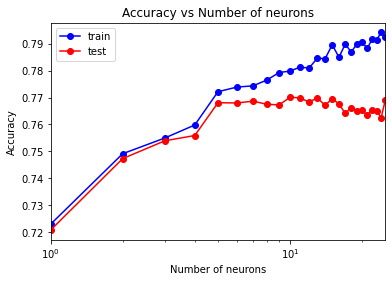

In [59]:
alpha_plot(hidden_layer, train_acc, test_acc, 'Number of neurons', 'Accuracy')

Оптимальное значение количества нейронов первого слоя:

In [60]:
neuron_opt_1

10

# Обучим нейронную сеть при найденном оптимальном значении alpha и оптимальном количестве нейронов первого слоя:

In [61]:
mlp_model = classifier_opt(alpha_opt, (neuron_opt_1,))
mlp_model.fit(x_train, y_train)

y_train_pred = mlp_model.predict(x_train)
y_test_pred = mlp_model.predict(x_test)

err_train = np.mean(y_train != y_train_pred)
err_test = np.mean(y_test != y_test_pred)

Ошибка на обучающей выборке:

In [62]:
err_train

0.2201521065550682

Ошибка на тестовой выборке:

In [63]:
err_test

0.22988317947880074

Добавим второй слой и определим количество нейронов 2-го скрытого слоя при оптимальном значении alpha и оптимальном количестве нейронов 1-го скрытого слоя при том же оптимальном alpha:

In [64]:
%%time
hidden_layer = np.arange(1, 25 + 1)
test_err = []
test_acc = []
train_err = []
train_acc = []

for neuroitem in tqdm(hidden_layer):
    mlp_model = classifier_opt(alpha_opt, (neuron_opt_1, neuroitem))
    
    mlp_model.fit(x_train, y_train)

    y_train_pred = mlp_model.predict(x_train)
    y_test_pred = mlp_model.predict(x_test)
    
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))
    
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)

neuron_opt_2 = hidden_layer[test_err == min_test_err]
neuron_opt_2 = neuron_opt_2[0]

 60%|██████    | 15/25 [16:03<14:32, 87.30s/it]C:\Users\denikolaev\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
100%|██████████| 25/25 [40:43<00:00, 97.75s/it] 

Wall time: 40min 43s


Минимальная ошибка на обучающей выборке:

In [65]:
min_train_err

0.20401593497243573

Минимальная ошибка на тестовой выборке:

In [66]:
min_test_err

0.22694224328077772

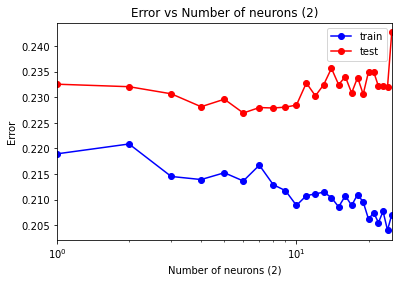

In [67]:
alpha_plot(hidden_layer, train_err, test_err, 'Number of neurons (2)', 'Error')

Рассмотрим, как менялась точность в зависимости от количества нейронов второго слоя:

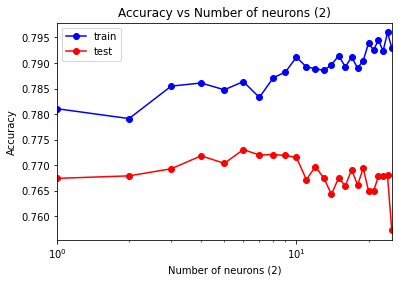

In [68]:
alpha_plot(hidden_layer, train_acc, test_acc, 'Number of neurons (2)', 'Accuracy')

Оптимальное значение количества нейронов второго слоя:

In [69]:
neuron_opt_2

6

# Обучим нейронную сеть при найденном оптимальном значении alpha, а также оптимальном количестве нейронов 1-го и 2-го скрытых слоёв

In [70]:
mlp_model = classifier_opt(alpha_opt, (neuron_opt_1, neuron_opt_2))

mlp_model.fit(x_train, y_train)

y_train_pred = mlp_model.predict(x_train)
y_test_pred = mlp_model.predict(x_test)

err_train = np.mean(y_train != y_train_pred)
err_test = np.mean(y_test != y_test_pred)

Ошибка на обучающей выборке: 

In [71]:
err_train

0.2136332541950022

Ошибка на тестовой выборке:

In [72]:
err_test

0.22694224328077772

# Выводы

При обучении классификатора было замечено, что при уменьшении количества нейронов ошибка на тестовой выборке уменьшается.

Так, например, ошибка на тестовой выборке:<br>
При 100 нейронах = 0.2675<br>
При  50 нейронах = 0.2506<br>
При  25 нейронах = 0.2334<br>

Поэтому подбор гиперпараметров проводился для слоёв из 25 нейронов. Наилучших результатов удалось достичь при следующих значениях:

In [73]:
alpha_opt

0.001

In [74]:
neuron_opt_1

10

In [75]:
neuron_opt_2

6

Тестовая ошибка в данном случае получается:

In [76]:
err_test

0.22694224328077772

Тем не менее, несмотря на высокий уровень ошибки в работе классификатора, удалось добиться лучших результатов в сравнении с классфикатором ближних соседей.